# Object Classification

Pada notebook ini saya akan coba menggunakan normalisasi `rescale=1. / 255` dan `preprocess_input`.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

from sklearn.metrics import classification_report

from matplotlib import pyplot as plt

In [3]:
# parameter yang digunakan
img_size = (299, 299, 3)
dir_img_train = "dataset/subset/train/"
dir_img_validation = "dataset/subset/validation/"
dir_img_test = "dataset/subset/test/"
batch_size = 16

lr_classifier = 1e-4
epoch_classifier = 10

# learning rate untuk fine tuning perlu diset kecil agar tidak merusak bobot yang sudah terbentuk
lr_tuning = 1e-6
epoch_tuning = 12

## Prepare Dataset

In [4]:
train_datagen = image.ImageDataGenerator(rescale=1. / 255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode="nearest")

# Note that the validation data should not be augmented!
test_datagen = image.ImageDataGenerator(rescale=1. / 255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    # target folder yang berisi kumpulan citra
    dir_img_train,
    # semua citra diubah ukurannya menjadi 299 x 299
    target_size=img_size[:2],
    batch_size=batch_size,
    # class_mode categorical harus disesuaikan dengan fungsi loss
    # Karena fungsi loss yang digunakan adalah categorical crossentropy
    # maka class_mode = categorical
    class_mode="categorical",
    shuffle=True,
    seed=1234)

validation_generator = test_datagen.flow_from_directory(
    dir_img_validation,
    target_size=img_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=1234)

test_generator = test_datagen.flow_from_directory(dir_img_test,
                                                  target_size=img_size[:2],
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=True,
                                                  seed=1234)

Found 12000 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.


## Mendefinisikan arsitektur classifier


In [6]:
def create_model():
    conv_base = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=img_size)

    conv_base.trainable = False

    input_layer = keras.Input(shape=img_size)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [7]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [8]:
# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

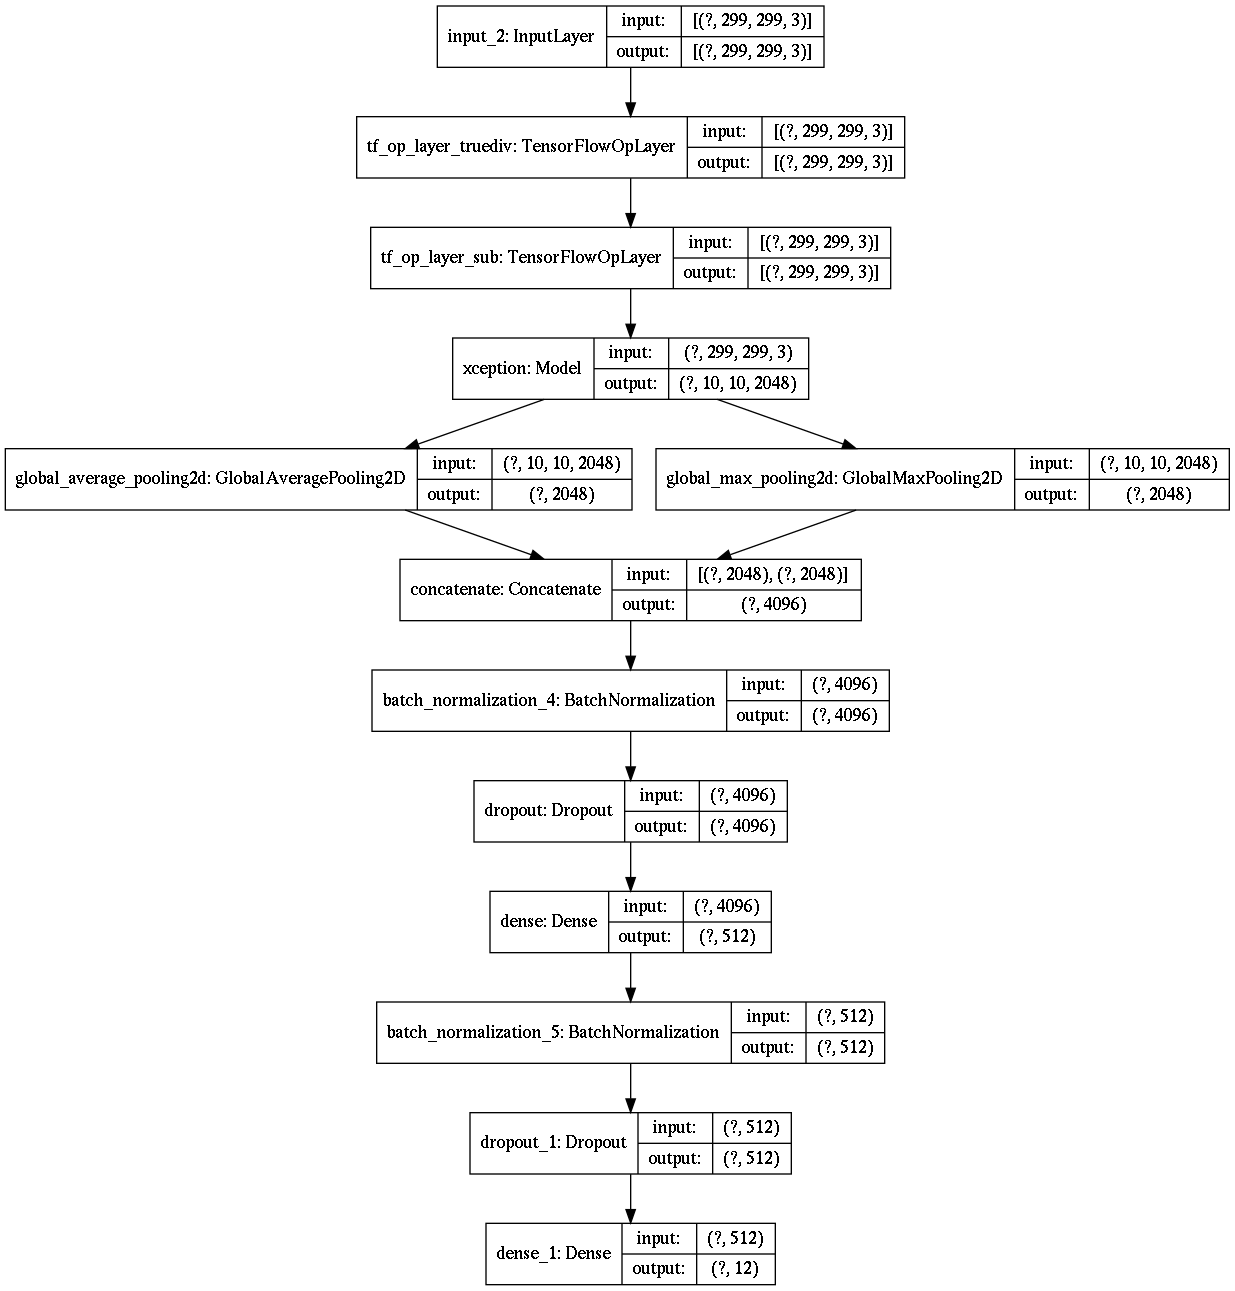

In [10]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

## Training Classifier

In [11]:
history = model.fit(train_generator,
                    epochs=epoch_classifier,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 750 steps, validate for 75 steps
Epoch 1/10
750/750 [==============================] - 180s 239ms/step - loss: 3.3580 - categorical_accuracy: 0.1252 - val_loss: 2.4326 - val_categorical_accuracy: 0.2108
Epoch 2/10
750/750 [==============================] - 168s 223ms/step - loss: 3.0227 - categorical_accuracy: 0.1523 - val_loss: 2.3134 - val_categorical_accuracy: 0.2883
Epoch 3/10
750/750 [==============================] - 169s 225ms/step - loss: 2.8705 - categorical_accuracy: 0.1653 - val_loss: 2.2355 - val_categorical_accuracy: 0.2958
Epoch 4/10
750/750 [==============================] - 167s 223ms/step - loss: 2.7270 - categorical_accuracy: 0.1781 - val_loss: 2.2093 - val_categorical_accuracy: 0.2967
Epoch 5/10
750/750 [==============================] - 166s 221ms/step - loss: 2.6763 - categorical_accuracy: 0.1791 - val_loss: 2.1605 - val_categorical_accuracy: 0.3175
Epoch 6/10
750/750 [==============================] - 163

In [12]:
model.metrics_names

['loss', 'categorical_accuracy']

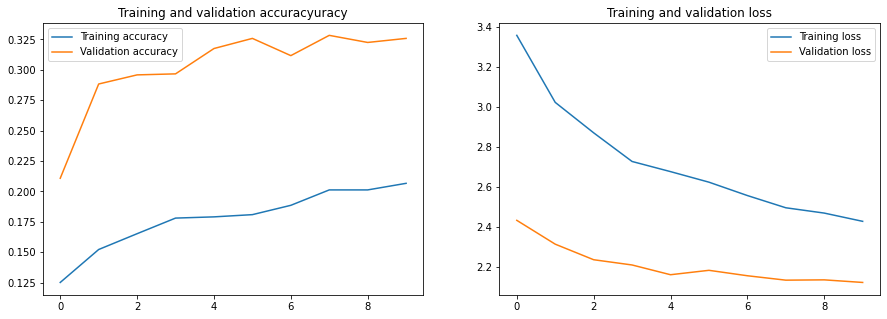

In [13]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [14]:
model.evaluate(validation_generator, verbose=1)

  ...
    to  
  ['...']
75/75 [==============================] - 10s 132ms/step - loss: 2.1219 - categorical_accuracy: 0.3258


[2.1218860371907553, 0.32583332]

In [15]:
y_true = list()
for idx in range(len(validation_generator.index_array)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [16]:
y_pred_prob = model.predict(validation_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

75/75 [==============================] - 10s 128ms/step


In [17]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.52      0.68      0.59       100
     cabinet       0.26      0.49      0.34       100
       chair       0.28      0.08      0.12       100
 coffe_maker       0.26      0.35      0.30       100
         fan       0.34      0.25      0.29       100
      kettle       0.39      0.47      0.43       100
        lamp       0.32      0.19      0.24       100
         mug       0.35      0.38      0.37       100
        sofa       0.37      0.38      0.37       100
     stapler       0.29      0.34      0.31       100
       table       0.20      0.08      0.11       100
     toaster       0.22      0.22      0.22       100

    accuracy                           0.33      1200
   macro avg       0.32      0.33      0.31      1200
weighted avg       0.32      0.33      0.31      1200



In [18]:
model.save("transfer_learning_classifier_preprocess_rescale.h5")

## Fine Tuning

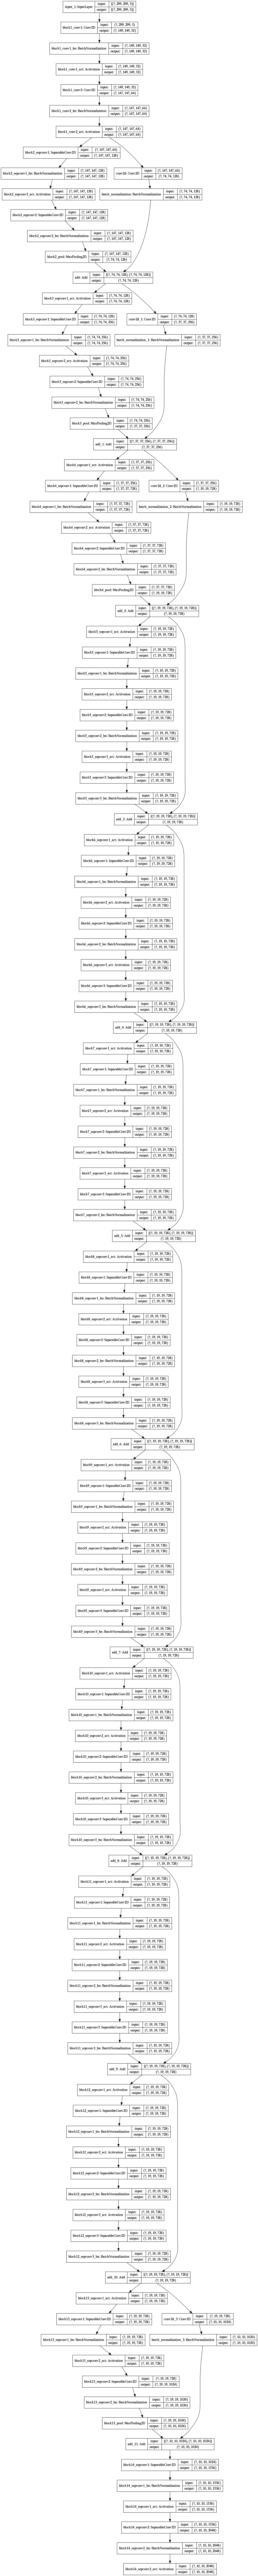

In [19]:
utils.plot_model(conv_base, show_layer_names=True, show_shapes=True)

In [20]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d False
block2_pool False
batch_normalization False
add False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_1 False
block3_pool False
batch_normalization_1 False
add_1 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_2 False
block4_pool False
batch_normalization_2 False
add_2 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepconv3_bn False
add_3 False
bl

In [21]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'add_7':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d False
block2_pool False
batch_normalization False
add False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_1 False
block3_pool False
batch_normalization_1 False
add_1 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_2 False
block4_pool False
batch_normalization_2 False
add_2 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepconv3_bn False
add_3 False
bl

In [23]:
with strategy.scope():
    model.compile(optimizer=optimizers.Adam(learning_rate=lr_tuning),
                  loss=losses.CategoricalCrossentropy(),
                  metrics=[metrics.CategoricalAccuracy()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [24]:
history = model.fit(train_generator,
                    epochs=epoch_tuning,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 750 steps, validate for 75 steps
Epoch 1/12
750/750 [==============================] - 170s 227ms/step - loss: 2.3989 - categorical_accuracy: 0.2151 - val_loss: 2.1128 - val_categorical_accuracy: 0.3242
Epoch 2/12
750/750 [==============================] - 165s 219ms/step - loss: 2.3983 - categorical_accuracy: 0.2097 - val_loss: 2.1080 - val_categorical_accuracy: 0.3283
Epoch 3/12
750/750 [==============================] - 164s 219ms/step - loss: 2.3857 - categorical_accuracy: 0.2237 - val_loss: 2.1045 - val_categorical_accuracy: 0.3308
Epoch 4/12
750/750 [==============================] - 164s 219ms/step - loss: 2.3699 - categorical_accuracy: 0.2179 - val_loss: 2.0991 - val_categorical_accuracy: 0.3208
Epoch 5/12
750/750 [==============================] - 164s 218ms/step - loss: 2.3853 - categorical_accuracy: 0.2191 - val_loss: 2.1076 - val_categorical_accuracy: 0.3300
Epoch 6/12
750/750 [==============================] - 164

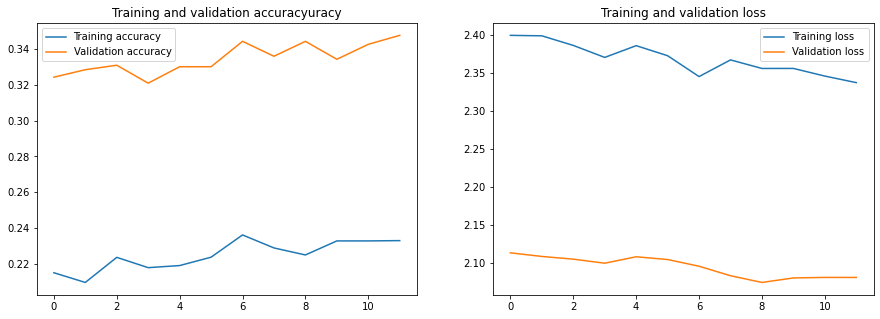

In [25]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [26]:
model.evaluate(validation_generator, verbose=1)

  ...
    to  
  ['...']
75/75 [==============================] - 10s 133ms/step - loss: 2.0804 - categorical_accuracy: 0.3475


[2.080398505528768, 0.3475]

In [27]:
y_true = list()
for idx in range(len(validation_generator.index_array)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [28]:
y_pred_prob = model.predict(validation_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

75/75 [==============================] - 10s 129ms/step


In [29]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.57      0.71      0.63       100
     cabinet       0.30      0.36      0.32       100
       chair       0.26      0.12      0.16       100
 coffe_maker       0.31      0.37      0.34       100
         fan       0.35      0.30      0.32       100
      kettle       0.38      0.49      0.43       100
        lamp       0.27      0.18      0.22       100
         mug       0.33      0.57      0.41       100
        sofa       0.32      0.49      0.39       100
     stapler       0.42      0.25      0.31       100
       table       0.25      0.15      0.19       100
     toaster       0.30      0.18      0.23       100

    accuracy                           0.35      1200
   macro avg       0.34      0.35      0.33      1200
weighted avg       0.34      0.35      0.33      1200



In [30]:
model.save("transfer_learning_fine_tune_preprocess_rescale.h5")